# Bay Area Hiking Trail Recommender

### Scope
The scope of this notebook is to provide instructions on how to setup the Bay Area Hiking project using the python API

### Background
Classification - A type of prediction problem that classifies values into discrete, final outcomes or classes. Multiclass classification is a classification problem that results in more than two outcomes (for example, "buy", "sell", or "hold").

### Requirements
- Python version 3.7.3
-  DataRobot API version 2.19.0. Small adjustments might be needed depending on the Python version and DataRobot API version you are using

### Key Documentation
- Full documentation of the Python package can be found here: https://datarobot-public-api-client.readthedocs-hosted.com
- Getting Started - https://datarobot-public-api-client.readthedocs-hosted.com/en/v2.25.0/setup/getting_started.html#installation

### You Will Learn How To:
1. Connect to the AI Catalog
2. Initiate Automl Project to conduct automated feature engineering, model training and testing, and develop a summary of modeling experiments
3. Plot Feature Impact/ Analyze Results
4. Deploy Model with a few lines of code

## ===================================================================

#### 1. Import Libraries

In [1]:
import datarobot as dr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### 2. Define Credentials
To make sure only authorized users access the DataRobot API, you need an API token. To get a token, log in to the DataRobot web UI, click your profile icon, and select Developer Tools. API tokens are shown under API Keys, and you can create a new one if needed.

In [2]:
endpoint = 'https://app.datarobot.com/api/v2'

# this can be found in DR UI - under developer tools section in the top right menu - Copy API token
api_token = 'API_TOKEN' 

#setup
dr.Client(token=api_token, endpoint=endpoint)

#### 3. Import/ Connect to Dataset in AI Catalog

To get the dataset ID - Go to AI catalog - click on dataset - access datasetid from info tab


In [4]:
dataset_id = '6272e862e2be8dea37f96e91'
dataset = dr.Dataset.get(dataset_id)
dataset.id == dataset_id

True

In [5]:
#Check dataset name 
dataset.name

'HikingData.zip'

#### 4. Initiate Automl Project to conduct feature engineering, model training and testing, and develop a leaderboard of models 
(This will be similar to what you see in UI) 
* project_name: Name of project
* target: String with target variable name
* you can also provide additional parameters like worker count, partitioning information, etc.

In [6]:
from datarobot import AUTOPILOT_MODE

project = dataset.create_project(project_name='Hiking-Recommender-PythonAPI') # set project name
project.set_target('Hike Name', mode=AUTOPILOT_MODE.QUICK) # set modeling mode
project.wait_for_autopilot()

# autopilot running - take a coffee break!

In progress: 8, queued: 0 (waited: 0s)
In progress: 8, queued: 0 (waited: 2s)
In progress: 8, queued: 0 (waited: 2s)
In progress: 8, queued: 0 (waited: 3s)
In progress: 8, queued: 0 (waited: 5s)
In progress: 8, queued: 0 (waited: 7s)
In progress: 8, queued: 0 (waited: 11s)
In progress: 8, queued: 0 (waited: 18s)
In progress: 7, queued: 0 (waited: 32s)
In progress: 5, queued: 0 (waited: 52s)
In progress: 4, queued: 0 (waited: 73s)
In progress: 1, queued: 0 (waited: 93s)
In progress: 7, queued: 9 (waited: 114s)
In progress: 8, queued: 8 (waited: 136s)
In progress: 8, queued: 8 (waited: 156s)
In progress: 8, queued: 8 (waited: 177s)
In progress: 8, queued: 7 (waited: 199s)
In progress: 6, queued: 4 (waited: 222s)
In progress: 8, queued: 1 (waited: 243s)
In progress: 7, queued: 0 (waited: 263s)
In progress: 1, queued: 0 (waited: 284s)
In progress: 1, queued: 0 (waited: 305s)
In progress: 1, queued: 0 (waited: 325s)
In progress: 0, queued: 0 (waited: 346s)
In progress: 0, queued: 0 (waited:

In [7]:
# For accessing a completed project later on - just add project id here (no need to re run the project again)
# Example: id can be found in url https://app.datarobot.com/projects/61c2b29cbc17bf11a702b611/models)

project = dr.Project.get(project_id='627a9c5d310bd7e3e689fcf4')

#### 5. Pick the best model


In [8]:
recommendation = dr.ModelRecommendation.get(project.id) 
recommended_model = recommendation.get_model()
print(f'Recommended model is {recommended_model}')
print ('Cross Validation Score Of',recommended_model.metrics['AUC']['crossValidation'])

Recommended model is Model('Keras Slim Residual Neural Network Classifier using Training Schedule (1 Layer: 64 Units)')
Cross Validation Score Of 0.99125


#### 6. Plotting Feature Impact/ Results


In [9]:
def plot_feature_impact(datarobot_model, title=None):
    """This function plots feature impact
    Input:
        datarobot_model: <Datarobot Model object>
        title : <string> --> title of graph
    """
    #Get feature impact
    feature_impacts = datarobot_model.get_or_request_feature_impact()

    #Sort feature impact based on normalised impact
    feature_impacts.sort(key=lambda x: x['impactNormalized'], reverse=True)

    fi_df = pd.DataFrame(feature_impacts) #Save feature impact in pandas dataframe
    fig, ax = plt.subplots(figsize=(14,5))
    b = sns.barplot(x="featureName", y="impactNormalized", data=fi_df[0:5], color="b")
    b.axes.set_title('Feature Impact' if not title else title,fontsize=20)

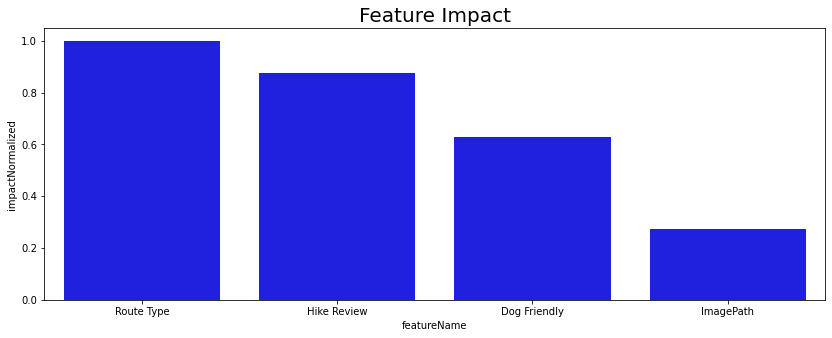

In [10]:
plot_feature_impact(recommended_model)

#### 7. Deploying the models
- Models are not deployed to the same server used to train models; they are deployed to one or more prediction servers.
- Prediction API: Any project can be called with the Prediction API if you have prediction servers. This is a simple REST API. Click on a model in the UI, then "Deploy Model" and "Activate now". You'll have access to a Python code snippet to help you interact with it. You can also deploy the model through the python API

In [13]:
# For creating a new deployment

# set server to deploy to
prediction_server_id = dr.PredictionServer.list()[1].id 

# set deployment details
deployment = dr.Deployment.create_from_learning_model( 
    model_id=recommended_model.id, 
    label='Bay Area Hiking Recommender', 
    description='Make hiking trail recommendations from some sample scenic images and hike descriptions (and help your friends and family select an appropriate hike this weekend!). Users do not have to convert text, images or field selections into a standardized format before making predictions. The deployment and app takes care of all the data processing, feature engineering, data standardization and integration, and model scoring tasks required to generate a nice output. Enjoy!', 
    default_prediction_server_id=prediction_server_id
)


In [14]:
# to verify deployment was created
for d in dr.Deployment.list():
    if d.label == 'Bay Area Hiking Recommender':
        deployment = d

# verify deployment and id
print(f'Deployment created: {deployment}, deployment id: {deployment.id}')

Deployment created: Deployment(Bay Area Hiking Recommender), deployment id: 6296dc8885308fd094fe3d30


## ==========================================================================

#### 8. Making Predictions For Visual AI - Notes

- Make Visual AI Predictions Tutorial - https://docs.datarobot.com/en/docs/tutorials/using-the-api/vai-pred.html
- Docs - https://docs.datarobot.com/en/docs/modeling/special-workflows/visual-ai/vai-predictions.html. 

The main methods are: 
1. UI Based
2. Batch for large datasets
3. API for real time/small datasets
4. Portable Prediction Server (PPS) - This is a DataRobot execution environment for DataRobot model packages (.mlpkg files) distributed as a self-contained Docker image


## ==========================================================================

- Author - Arjun Arora - Customer Facing Data Scientist at Datarobot
- Dated - May 31, 2022